# **Neural Machine Translation using RNN**

In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time
from nltk.translate.bleu_score import sentence_bleu
#import streamlit

# stores the checkpoints on the google drive (too big to run locally, can be done but resource extensive.)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from nltk.translate.bleu_score import SmoothingFunction

###Cell below loads both datasets

Dataset 1 from: http://www.manythings.org/anki/

Dataset 2 from: https://www.tensorflow.org/datasets/catalog/ted_hrlr_translate#ted_hrlr_translatept_to_en

In [ ]:
# variables use s for short and l for long dataset
# dataset 1 which have short sequences (final name: tf_dataset_s)
# sample: Get up.	Levante-se!
# sample: Get up.	Levantem-se!
# this method pre-process the sentence and adds spaces before punctuation and adds start and end tags
def process_sentence(w):
  w = ''.join(c for c in unicodedata.normalize('NFD', w.lower().strip())
                 if unicodedata.category(c) != 'Mn')
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
  w = w.strip()
  w = '<start> ' + w + ' <end>'
  return w

#loads the portugese text file and only 50,000 lines
lines = io.open("/content/drive/MyDrive/Colab Notebooks/por.txt", encoding='UTF-8').read().strip().split('\n')
word_pairs = [[process_sentence(w) for w in line.split('\t')[:2]] for line in lines[:50000]]
lan1, lan2 = zip(*word_pairs)

# it uses tensorflow tokenizer utility class and creates indexes of words using the vocabulary provided by our dataset.
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(lang) # fitting the vocabulary of our language and creating indexes
  tensor = lang_tokenizer.texts_to_sequences(lang)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post') # padding sequences to make them equal sized vectors
  return tensor, lang_tokenizer

source_tensor_s, source_lang_tok_s = tokenize(lan1) # returns a integer tensor for source language english with each integer being the index of a token in a dictionary
target_tensor_s, target_lang_tok_s = tokenize(lan2) # returns a integer tensor for source language portuguese with each integer being the index of a token in a dictionary
embed_size_src_s = len(source_lang_tok_s.word_index)+1 # size of dictionary trained using tokenizer utility class
embed_size_trg_s = len(target_lang_tok_s.word_index)+1 # to be used in creating embedding layer
max_len_src_s = source_tensor_s.shape[1] # max length of source indexes to find 
max_len_trg_s = target_tensor_s.shape[1] 

# train, test, validation ratios
TRAIN_RATIO = 0.75
VALIDATION_RATIO = 0.15
TEST_RATIO = 0.10

source_tensor_s_train, source_tensor_s_test, target_tensor_s_train, target_tensor_s_test = train_test_split(source_tensor_s, target_tensor_s, test_size=1-TRAIN_RATIO)
source_tensor_s_val, source_tensor_s_test, target_tensor_s_val, target_tensor_s_test = train_test_split(source_tensor_s_test, target_tensor_s_test, test_size=TEST_RATIO/(TEST_RATIO + VALIDATION_RATIO))

input_length_s = len(source_tensor_s_train)
# final dataset 1 to be used by model
tf_dataset_s = tf.data.Dataset.from_tensor_slices((source_tensor_s_train, target_tensor_s_train)).shuffle(len(source_tensor_s_train)).batch(64, drop_remainder = True)

# dataset 2 which have long sequences (final name: tf_dataset_l)
# sample: and they 've put it deep down in an iron mine in minnesota , ok , deep under the ground , and in fact , in the last couple of days announced the most sensitive results so far .	colocaram-no bem no fundo duma mina de ferro no minnesota , nos últimos dois dias anunciaram os resultados mais sensíveis até agora 

# loads from tensorflow databases
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True, as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

# tokenized using tensorflow tokenizer utility class and creates indexes of words using the vocabulary provided by our dataset.
def tokenize_lang(lang1, lang2):
  lang1_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang1_tokenizer.fit_on_texts(lang1) # fitting the vocabulary of our language and creating indexes
  tensor1 = lang1_tokenizer.texts_to_sequences(lang1) 
  tensor1 = tf.keras.preprocessing.sequence.pad_sequences(tensor1, padding='post') # padding sequences to make them equal sized vectors

  lang2_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang2_tokenizer.fit_on_texts(lang2)
  tensor2 = lang2_tokenizer.texts_to_sequences(lang2)
  tensor2 = tf.keras.preprocessing.sequence.pad_sequences(tensor2, padding='post')

  return tensor1, tensor2, lang1_tokenizer, lang2_tokenizer

train_en = train_examples.map(lambda pt, en: en)
train_pt = train_examples.map(lambda pt, en: pt)
valid_en = val_examples.map(lambda pt, en: en)
valid_pt = val_examples.map(lambda pt, en: pt)
en_dataset = []
pt_dataset = []
for line in train_en:
  en_dataset.append(process_sentence(line.numpy().decode('utf-8')))
for line in train_pt:
  pt_dataset.append(process_sentence(line.numpy().decode('utf-8')))
for line in valid_en:
  en_dataset.append(process_sentence(line.numpy().decode('utf-8')))
for line in valid_pt:
  pt_dataset.append(process_sentence(line.numpy().decode('utf-8')))
en_dataset = en_dataset[:40000]
pt_dataset = pt_dataset[:40000] # limiting total number of examples to run faster

source_tensor_l,target_tensor_l, source_lang_tok_l, target_lang_tok_l = tokenize_lang(en_dataset, pt_dataset)
source_tensor_l = source_tensor_l[:,:28] # limiting tensor shape to run faster which just removes bunch of padded sequences at the end.
target_tensor_l = target_tensor_l[:,:28]
embed_size_src_l = len(source_lang_tok_l.word_index)+1
embed_size_trg_l = len(target_lang_tok_l.word_index)+1 
max_len_src_l = source_tensor_l.shape[1]
max_len_trg_l = target_tensor_l.shape[1]

source_tensor_l_train, source_tensor_l_test, target_tensor_l_train, target_tensor_l_test = train_test_split(source_tensor_l, target_tensor_l, test_size=1-TRAIN_RATIO)
source_tensor_l_val, source_tensor_l_test, target_tensor_l_val, target_tensor_l_test = train_test_split(source_tensor_l_test, target_tensor_l_test, test_size=TEST_RATIO/(TEST_RATIO+VALIDATION_RATIO))
input_length_l = len(source_tensor_l_train)
# final dataset2 to be used by model
tf_dataset_l = tf.data.Dataset.from_tensor_slices((source_tensor_l_train, target_tensor_l_train)).shuffle(len(source_tensor_l_train)).batch(64, drop_remainder = True)

2021-04-21 23:17:35.272 INFO    absl: Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: ted_hrlr_translate/pt_to_en/1.0.0
2021-04-21 23:17:35.393 INFO    absl: Load dataset info from /tmp/tmp3urcp6w9tfds
2021-04-21 23:17:35.397 INFO    absl: Field info.description from disk and from code do not match. Keeping the one from code.
2021-04-21 23:17:35.398 INFO    absl: Field info.config_name from disk and from code do not match. Keeping the one from code.
2021-04-21 23:17:35.402 INFO    absl: Field info.config_description from disk and from code do not match. Keeping the one from code.
2021-04-21 23:17:35.404 INFO    absl: Field info.citation from disk and from code do not match. Keeping the one from code.
2021-04-21 23:17:35.408 INFO    absl: Generating dataset ted_hrlr_translate (/root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0)


2021-04-21 23:17:35.851 INFO    absl: Downloading http://www.phontron.com/data/qi18naacl-dataset.tar.gz into /root/tensorflow_datasets/downloads/phontron.com_qi18naacl-datasetLVhDyvf9PQ-GjP4jim31ESZuvRjHI5wpNhR5SJvsNOo.tar.gz.tmp.6f0f14d860d849138fdb6fcc2366bba0...
2021-04-21 23:17:45.031 INFO    absl: Generating split train


Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteJGSVP9/ted_hrlr_translate-train.tfrecord


2021-04-21 23:17:54.086 INFO    absl: Done writing /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteJGSVP9/ted_hrlr_translate-train.tfrecord. Shard lengths: [51785]
2021-04-21 23:17:54.089 INFO    absl: Generating split validation


Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteJGSVP9/ted_hrlr_translate-validation.tfrecord


2021-04-21 23:17:54.405 INFO    absl: Done writing /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteJGSVP9/ted_hrlr_translate-validation.tfrecord. Shard lengths: [1193]
2021-04-21 23:17:54.412 INFO    absl: Generating split test


Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteJGSVP9/ted_hrlr_translate-test.tfrecord


2021-04-21 23:17:54.849 INFO    absl: Done writing /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteJGSVP9/ted_hrlr_translate-test.tfrecord. Shard lengths: [1803]
2021-04-21 23:17:54.854 INFO    absl: Skipping computing stats for mode ComputeStatsMode.SKIP.
2021-04-21 23:17:54.860 INFO    absl: Constructing tf.data.Dataset for split None, from /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0


Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


##Cell Below create the architecture of our Neural Machine Translation

In [ ]:
# this class implements the Attention Mechanism by inheriting the keras layers to create units.
# implements Bahdanau's Attention formulas from paper
# attention mechanism allows to pay attention to relevan source context as language is translated
class Attention_Mechanism(keras.layers.Layer):
  def __init__(self, units): # initializes units for internal weights and encoder matching units
    super().__init__()
    # layers without activations
    self.internal_weight_1 = tf.keras.layers.Dense(units) 
    self.internal_weight_2 = tf.keras.layers.Dense(units)
    self.internal_encoder = tf.keras.layers.Dense(1)

  def call(self, state, encoder_output): # attention layer receives the state and encoder output from encoder and merges context cector with decoder
    state_transform = tf.expand_dims(state, 1) 
    # the allignment score using the bahdanau's additive style is calculated using decoder hidden state and encoder output
    alignment_score = self.internal_encoder(tf.nn.tanh(self.internal_weight_1(state_transform)+self.internal_weight_2(encoder_output)))
    attention_weights = tf.nn.softmax(alignment_score, axis = 1) # softmax function of alignment scores
    context_vector = tf.reduce_sum(attention_weights*encoder_output, axis = 1) # context vector which is used for predictions.
    return attention_weights, context_vector

# this class implements the encoder module using LSTM cells
class LSTM_Encoder(keras.Model):
  def __init__(self, units, batch_size, embed_size, embedding_output_size):
    super().__init__()
    self.units = units
    self.batch_size = batch_size
    # embedding layer is used to convert indexes from tokens into dense vectors of fixed size which provides dense representation of words
    # and their relative meanings.
    self.embedding_layer = tf.keras.layers.Embedding(embed_size, embedding_output_size, mask_zero=True) # embeds from embed size to embed output size
    # Long short Term memory layer which returns the last output as well full sequence in the connection
    self.lstm_layer = tf.keras.layers.LSTM(self.units, recurrent_initializer = 'glorot_uniform', return_sequences = True, return_state = True)

  # initialize the hidden state of the LSTM layer
  def create_hidden_state(self):
    return [tf.zeros((self.batch_size, self.units)), tf.zeros((self.batch_size, self.units))]
  # takes in input from tokenized source language and hidden layer initialized above
  def call(self, input, hidden_state):
    input = self.embedding_layer(input)
    output, state, cell_state = self.lstm_layer(input, initial_state = hidden_state)
    # returns the output, state and cell state of LSTM
    return output, state, cell_state

# this class implements the encoder module using GRU cells which has less gates and less complex
class GRU_Encoder(keras.Model):
  def __init__(self, units, batch_size, embed_size, embedding_output_size):
    super().__init__()
    self.units = units
    self.batch_size = batch_size
    self.embedding_layer = tf.keras.layers.Embedding(embed_size, embedding_output_size, mask_zero=True)
    self.gru_layer = tf.keras.layers.GRU(self.units, recurrent_initializer = 'glorot_uniform', return_sequences = True, return_state = True)

  def create_hidden_state(self):
    return tf.zeros((self.batch_size, self.units))
  
  def call(self, input, hidden_state):
    input = self.embedding_layer(input)
    output, state = self.gru_layer(input, initial_state = hidden_state)
    return output, state

# this class implements the decoder module using LSTM cells
class LSTM_Decoder(keras.Model):
  def __init__(self, units, batch_size, embed_size, embedding_output_size):
    super().__init__()
    self.units = units
    self.batch_size = batch_size
    self.embedding_layer = tf.keras.layers.Embedding(embed_size, embedding_output_size, mask_zero=True) # embeds from embed size to embed output size and masks the padded sequence
    self.lstm_layer = tf.keras.layers.LSTM(self.units, recurrent_initializer = 'glorot_uniform', return_sequences = True, return_state = True)
    self.projection_layer = tf.keras.layers.Dense(embed_size) # projection layer is the dense layer to turn the top hidden states into logit vectors
    self.attention_layer = Attention_Mechanism(self.units)
  # decoder uses the context vector obtained from attention layer found using encoder output and concatenates with the input from target language 
  # and concatenates it and generates an output using teacher feeding method or normal depending on training or evaluating.
  def call(self, input, hidden_state, encoder_output):
    attention_weights, context_vector = self.attention_layer(hidden_state, encoder_output)
    context_vector_transform = tf.expand_dims(context_vector, 1)
    input = self.embedding_layer(input)
    input = tf.concat([context_vector_transform, input], axis = -1)
    output, state, cell_state = self.lstm_layer(input)
    output = tf.reshape(output,(-1, output.shape[2]))
    input = self.projection_layer(output)
    return input, state, cell_state, attention_weights # returns the final output from the projection layer

# this class implements the decoder module using GRU cells
class GRU_Decoder(keras.Model):
  def __init__(self, units, batch_size, embed_size, embedding_output_size):
    super().__init__()
    self.units = units
    self.batch_size = batch_size
    self.embedding_layer = tf.keras.layers.Embedding(embed_size, embedding_output_size, mask_zero=True)
    self.gru_layer = tf.keras.layers.GRU(self.units, recurrent_initializer = 'glorot_uniform', return_sequences = True, return_state = True)
    self.projection_layer = tf.keras.layers.Dense(embed_size)
    self.attention_layer = Attention_Mechanism(self.units)
  
  def call(self, input, hidden_state, encoder_output):
    attention_weights, context_vector = self.attention_layer(hidden_state, encoder_output)
    context_vector_transform = tf.expand_dims(context_vector, 1)
    input = self.embedding_layer(input)
    input = tf.concat([context_vector_transform, input], axis = -1)
    output, state = self.gru_layer(input)
    output = tf.reshape(output,(-1, output.shape[2]))
    input = self.projection_layer(output)
    return input, state, attention_weights


## Cell Below is used for initializing the custom layers created and helper functions to train the NMT.

In [ ]:
batch_size, embedding_output_size, units = 64, 256, 1024
checkpoint_directory = '/content/drive/MyDrive/Colab Notebooks'+'/latest_checks'  # stores the checkpoints after training
# if drive does not lets you store comment out checkpoint part, we tested it allows different user to create run
prefix_l_s = os.path.join(checkpoint_directory, "nmt_l_s")

prefix_g_s = os.path.join(checkpoint_directory, "nmt_g_s")

prefix_g_l = os.path.join(checkpoint_directory, "nmt_g_l")
#prefix_g_l_d = os.path.join(checkpoint_directory, "nmt_g_l_d")
prefix_l_l = os.path.join(checkpoint_directory, "nmt_l_l")
#prefix_l_l_d = os.path.join(checkpoint_directory, "nmt_l_l_d")

# adam optimizer is used for training with its default values 
optimizer_g_s = tf.keras.optimizers.Adam()
optimizer_g_l = tf.keras.optimizers.Adam()
optimizer_l_s = tf.keras.optimizers.Adam()
optimizer_l_l = tf.keras.optimizers.Adam()

# initializing encoder and decoder for both gru and lstm for each sequence short and long
gru_enc_s = GRU_Encoder(units, batch_size, embed_size_src_s, embedding_output_size)
gru_dec_s = GRU_Decoder(units, batch_size, embed_size_trg_s, embedding_output_size)
checkpoint_g_s = tf.train.Checkpoint(optimizer=optimizer_g_s, encoder=gru_enc_s, decoder=gru_dec_s)

gru_enc_l = GRU_Encoder(units, batch_size, embed_size_src_l, embedding_output_size)
gru_dec_l = GRU_Decoder(units, batch_size, embed_size_trg_l, embedding_output_size)
checkpoint_g_l = tf.train.Checkpoint(optimizer=optimizer_g_l, encoder=gru_enc_l, decoder=gru_dec_l)

lstm_enc_s = LSTM_Encoder(units, batch_size, embed_size_src_s, embedding_output_size)
lstm_dec_s = LSTM_Decoder(units, batch_size, embed_size_trg_s, embedding_output_size)
checkpoint_l_s = tf.train.Checkpoint(optimizer=optimizer_l_s, encoder=lstm_enc_s, decoder=lstm_dec_s)

lstm_enc_l = LSTM_Encoder(units, batch_size, embed_size_src_l, embedding_output_size)
lstm_dec_l = LSTM_Decoder(units, batch_size, embed_size_trg_l, embedding_output_size)
checkpoint_l_l = tf.train.Checkpoint(optimizer=optimizer_l_l, encoder=lstm_enc_l, decoder=lstm_dec_l)

# to find accuracy of the training batches (it is not evaluating properly at the moment)
def accuracy_func(true_value, predicted): 
  max = tf.cast(tf.argmax(predicted, axis=1), dtype=true_value.dtype)
  accuracy = tf.equal(true_value, max)
  attention_mask = tf.logical_not(tf.math.equal(true_value,0))
  accuracy = tf.logical_and(attention_mask, accuracy)
  accuracy = tf.cast(accuracy, dtype = tf.float32)
  attention_mask = tf.cast(attention_mask, dtype=accuracy.dtype)
  accuracy = tf.reduce_sum(accuracy*attention_mask)
  return accuracy

# to find the loss value of our training to optimize using gradient descent
def loss_func(true_value, predicted):
  sparse_cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
  loss_logits = sparse_cross_entropy(true_value, predicted)
  attention_mask = tf.logical_not(tf.math.equal(true_value,0))
  attention_mask = tf.cast(attention_mask, dtype=loss_logits.dtype)
  loss_logits = tf.reduce_mean(attention_mask*loss_logits)
  return loss_logits

def apply_lstm_grad():
  ## tf.function is omitted when training short sequences as it can only initialize once per RNN type but it fastens training time for long sequences
  #@tf.function 
  def lstm_learning(source, target, encoder, encoder_state_l, decoder, target_lang_token, optimizer, loss_value_l = 0, accuracy_value_l = 0):
    with tf.GradientTape() as tape:
      encoder_output_l, encoder_state_l, encoder_cell_state_l = encoder(source, encoder_state_l) # passing input to encoder which returns output and its hidden state
      decoder_state_l = encoder_state_l
      decoder_input_l = tf.expand_dims([target_lang_token.word_index['<start>']]*batch_size, 1)
      for i in range(1, target.shape[1]):
        # predictions are returned by decoder and loss is calculated, initially start token is sent as input, decoder state is reused
        predicted_l, decoder_state_l, decoder_cell_state_l, decoder_attention_weights_l = decoder(decoder_input_l, decoder_state_l, encoder_output_l)
        loss_value_l += loss_func(target[:,i], predicted_l) # end and start token ignored using loop and decoder_input
        accuracy_value_l += accuracy_func(target[:,i], predicted_l)
        # updating target input and feeding one at a time
        decoder_input_l = tf.expand_dims(target[:,i], 1)
    current_batch_loss_l = (loss_value_l/int(target.shape[1]))
    current_batch_acc_l = (accuracy_value_l/int(target.shape[1]))
    trainable_weights_l = encoder.trainable_variables + decoder.trainable_variables
    grads_l = tape.gradient(loss_value_l, trainable_weights_l) # finding gradients 
    optimizer.apply_gradients(zip(grads_l, trainable_weights_l)) # applying gradients backpropstep
    return current_batch_loss_l, current_batch_acc_l, encoder, decoder
  return lstm_learning

def apply_gru_grad():
  #@tf.function
  def gru_learning(source, target, encoder, encoder_state_g, decoder, target_lang_token, optimizer, loss_value_g = 0, accuracy_value_g = 0):
    with tf.GradientTape() as tape:
      encoder_output_g, encoder_state_g = encoder(source, encoder_state_g)
      decoder_state_g = encoder_state_g
      decoder_input_g = tf.expand_dims([target_lang_token.word_index['<start>']]*batch_size, 1)
      for i in range(1, target.shape[1]):
        predicted_g, decoder_state_g, decoder_attention_weights_g = decoder(decoder_input_g, decoder_state_g, encoder_output_g)
        loss_value_g += loss_func(target[:,i], predicted_g) # end and start token ignored using loop and decoder_input
        accuracy_value_g += accuracy_func(target[:,i], predicted_g)
        # updating target input and feeding one at a time
        decoder_input_g = tf.expand_dims(target[:,i], 1)
    current_batch_loss_g = (loss_value_g/int(target.shape[1]))
    current_batch_acc_g = (accuracy_value_g/int(target.shape[1]))
    trainable_weights_g = encoder.trainable_variables + decoder.trainable_variables
    grads_g = tape.gradient(loss_value_g, trainable_weights_g)
    optimizer.apply_gradients(zip(grads_g, trainable_weights_g))
    return current_batch_loss_g, current_batch_acc_g, encoder, decoder
  return gru_learning

apply_lstm_step = apply_lstm_grad()
apply_gru_step = apply_gru_grad()
 
def train_gru(epochs, dataset, input_length, target_lang_token, optimizer, gru_enc, gru_dec):
  clock = time.time()
  print("NMT GRU Training....")
  for epoch in range(epochs):
    final_loss = 0
    encoder_state = gru_enc.create_hidden_state() # initial state is passed
    for (current_batch, (source_lang, target_lang)) in enumerate(dataset.take(input_length)):
      current_batch_loss, current_batch_accuracy, gru_enc, gru_dec = apply_gru_step(source_lang, target_lang, gru_enc, encoder_state, gru_dec, target_lang_token, optimizer)
      final_loss += current_batch_loss

      if current_batch % 100 == 0:
        print(f'Epoch no. {epoch+1} Batch {current_batch} Loss = {current_batch_loss.numpy():.3f} Accuracy = {current_batch_accuracy.numpy():.3f} \n')
    
  print(f'Total time for all Epochs: {time.time()-clock:.2f} sec\n')
  # returns the trained gru encoder and decoder
  return gru_enc, gru_dec

def train_lstm(epochs, dataset, input_length, target_lang_token, optimizer, lstm_enc, lstm_dec):

  clock = time.time()
  print("NMT LSTM Training....")
  for epoch in range(epochs):
    final_loss = 0
    encoder_state = lstm_enc.create_hidden_state()
    for (current_batch, (source_lang, target_lang)) in enumerate(dataset.take(input_length)):
      current_batch_loss, current_batch_accuracy, lstm_enc, lstm_dec = apply_lstm_step(source_lang, target_lang, lstm_enc, encoder_state, lstm_dec, target_lang_token, optimizer)
      final_loss += current_batch_loss

      if current_batch % 100 == 0:
        print(f'Epoch no. {epoch+1} Batch {current_batch} Loss = {current_batch_loss.numpy():.3f} Accuracy = {current_batch_accuracy.numpy():.3f} \n')
    
  print(f'Total time for all Epochs: {time.time()-clock:.2f} sec\n')
  # returns the trained lstm encoder and decoder which can now translate
  return lstm_enc, lstm_dec


### Train methods
(update the epoch value to shorten training)
Do not run unless training. Model data is loaded from checkpoints.

In [ ]:
# LSTM on short sequence, trained encoder and decoder is returned
lstm_enc_s, lstm_dec_s = train_lstm(10, tf_dataset_s, input_length_s, target_lang_tok_s, optimizer_l_s, lstm_enc_s, lstm_dec_s)
checkpoint_l_s.save(file_prefix = prefix_l_s)

NMT LSTM Training....
Epoch no. 1 Batch 0 Loss = 3.229 Accuracy = 0.000 

Epoch no. 1 Batch 100 Loss = 1.657 Accuracy = 7.625 

Epoch no. 1 Batch 200 Loss = 1.570 Accuracy = 8.875 

Epoch no. 1 Batch 300 Loss = 1.419 Accuracy = 8.938 

Epoch no. 1 Batch 400 Loss = 1.379 Accuracy = 9.188 

Epoch no. 1 Batch 500 Loss = 1.316 Accuracy = 9.750 

Epoch no. 2 Batch 0 Loss = 1.279 Accuracy = 10.625 

Epoch no. 2 Batch 100 Loss = 1.141 Accuracy = 11.000 

Epoch no. 2 Batch 200 Loss = 1.188 Accuracy = 10.812 

Epoch no. 2 Batch 300 Loss = 1.063 Accuracy = 11.500 

Epoch no. 2 Batch 400 Loss = 1.118 Accuracy = 11.875 

Epoch no. 2 Batch 500 Loss = 1.041 Accuracy = 12.375 

Epoch no. 3 Batch 0 Loss = 1.001 Accuracy = 12.688 

Epoch no. 3 Batch 100 Loss = 0.950 Accuracy = 12.625 

Epoch no. 3 Batch 200 Loss = 0.908 Accuracy = 12.812 

Epoch no. 3 Batch 300 Loss = 0.886 Accuracy = 12.750 

Epoch no. 3 Batch 400 Loss = 0.933 Accuracy = 13.125 

Epoch no. 3 Batch 500 Loss = 0.864 Accuracy = 13.188 



'/content/drive/MyDrive/Colab Notebooks/latest_checks/nmt_l_s-1'

In [ ]:
# GRU on short sequence, trained encoder and decoder is returned
gru_enc_s, gru_dec_s = train_gru(10, tf_dataset_s, input_length_s, target_lang_tok_s, optimizer_g_s, gru_enc_s, gru_dec_s)
checkpoint_g_s.save(file_prefix = prefix_g_s)

NMT GRU Training....
Epoch no. 1 Batch 0 Loss = 3.399 Accuracy = 0.000 

Epoch no. 1 Batch 100 Loss = 1.655 Accuracy = 7.625 

Epoch no. 1 Batch 200 Loss = 1.471 Accuracy = 9.000 

Epoch no. 1 Batch 300 Loss = 1.224 Accuracy = 10.688 

Epoch no. 1 Batch 400 Loss = 1.209 Accuracy = 10.625 

Epoch no. 1 Batch 500 Loss = 1.194 Accuracy = 12.688 

Epoch no. 2 Batch 0 Loss = 1.041 Accuracy = 11.688 

Epoch no. 2 Batch 100 Loss = 1.031 Accuracy = 13.188 

Epoch no. 2 Batch 200 Loss = 1.039 Accuracy = 12.562 

Epoch no. 2 Batch 300 Loss = 0.913 Accuracy = 13.000 

Epoch no. 2 Batch 400 Loss = 0.892 Accuracy = 13.438 

Epoch no. 2 Batch 500 Loss = 0.907 Accuracy = 13.250 

Epoch no. 3 Batch 0 Loss = 0.708 Accuracy = 15.375 

Epoch no. 3 Batch 100 Loss = 0.684 Accuracy = 14.812 

Epoch no. 3 Batch 200 Loss = 0.684 Accuracy = 15.000 

Epoch no. 3 Batch 300 Loss = 0.548 Accuracy = 16.750 

Epoch no. 3 Batch 400 Loss = 0.587 Accuracy = 16.688 

Epoch no. 3 Batch 500 Loss = 0.600 Accuracy = 16.500 

'/content/drive/MyDrive/Colab Notebooks/latest_checks/nmt_g_s-1'

In [ ]:
# LSTM on long sequence, trained encoder and decoder is returned
lstm_enc_l, lstm_dec_l = train_lstm(10, tf_dataset_l, input_length_l, target_lang_tok_l, optimizer_l_l, lstm_enc_l, lstm_dec_l)
checkpoint_l_l.save(file_prefix = prefix_l_l)

NMT LSTM Training....
Epoch no. 1 Batch 0 Loss = 5.085 Accuracy = 0.000 

Epoch no. 1 Batch 100 Loss = 3.736 Accuracy = 2.000 

Epoch no. 1 Batch 200 Loss = 4.079 Accuracy = 2.214 

Epoch no. 1 Batch 300 Loss = 3.938 Accuracy = 1.821 

Epoch no. 1 Batch 400 Loss = 3.515 Accuracy = 1.714 

Epoch no. 2 Batch 0 Loss = 3.424 Accuracy = 3.964 

Epoch no. 2 Batch 100 Loss = 3.814 Accuracy = 5.357 

Epoch no. 2 Batch 200 Loss = 3.202 Accuracy = 5.786 

Epoch no. 2 Batch 300 Loss = 3.231 Accuracy = 6.714 

Epoch no. 2 Batch 400 Loss = 2.850 Accuracy = 7.000 

Epoch no. 3 Batch 0 Loss = 3.468 Accuracy = 6.857 

Epoch no. 3 Batch 100 Loss = 3.022 Accuracy = 7.714 

Epoch no. 3 Batch 200 Loss = 3.042 Accuracy = 7.429 

Epoch no. 3 Batch 300 Loss = 2.909 Accuracy = 6.714 

Epoch no. 3 Batch 400 Loss = 2.905 Accuracy = 7.071 

Epoch no. 4 Batch 0 Loss = 2.660 Accuracy = 8.571 

Epoch no. 4 Batch 100 Loss = 2.793 Accuracy = 8.964 

Epoch no. 4 Batch 200 Loss = 2.627 Accuracy = 8.393 

Epoch no. 4 Ba

'/content/drive/MyDrive/Colab Notebooks/latest_checks/nmt_l_l-1'

In [ ]:
# GRU on long sequence, trained encoder and decoder is returned
gru_enc_l, gru_dec_l = train_gru(10, tf_dataset_l, input_length_l, target_lang_tok_l, optimizer_g_l, gru_enc_l, gru_dec_l)
checkpoint_g_l.save(file_prefix = prefix_g_l)

NMT GRU Training....
Epoch no. 1 Batch 0 Loss = 5.201 Accuracy = 0.000 

Epoch no. 1 Batch 100 Loss = 3.540 Accuracy = 2.429 

Epoch no. 1 Batch 200 Loss = 3.581 Accuracy = 3.929 

Epoch no. 1 Batch 300 Loss = 3.485 Accuracy = 5.071 

Epoch no. 1 Batch 400 Loss = 3.525 Accuracy = 5.857 

Epoch no. 2 Batch 0 Loss = 2.819 Accuracy = 5.179 

Epoch no. 2 Batch 100 Loss = 3.492 Accuracy = 5.893 

Epoch no. 2 Batch 200 Loss = 3.280 Accuracy = 6.821 

Epoch no. 2 Batch 300 Loss = 2.573 Accuracy = 5.679 

Epoch no. 2 Batch 400 Loss = 2.788 Accuracy = 6.107 

Epoch no. 3 Batch 0 Loss = 3.122 Accuracy = 7.143 

Epoch no. 3 Batch 100 Loss = 2.739 Accuracy = 6.929 

Epoch no. 3 Batch 200 Loss = 3.105 Accuracy = 7.857 

Epoch no. 3 Batch 300 Loss = 3.346 Accuracy = 7.821 

Epoch no. 3 Batch 400 Loss = 3.049 Accuracy = 7.214 

Epoch no. 4 Batch 0 Loss = 2.669 Accuracy = 7.607 

Epoch no. 4 Batch 100 Loss = 2.696 Accuracy = 7.786 

Epoch no. 4 Batch 200 Loss = 2.683 Accuracy = 7.786 

Epoch no. 4 Bat

'/content/drive/MyDrive/Colab Notebooks/latest_checks/nmt_g_l-1'

# Cell below provides evaluation method to translate the sentence.

In [ ]:
# this function takes a sentence, a particular trained encoder and decoder to find the translation of the sentence
def translate(sentence, src_lang_tok, tar_lang_tok, max_len_src, max_len_trg, encoder, decoder, name):
  result = ''
  # sentence is processed same as input
  sentence = process_sentence(sentence)
  input = [src_lang_tok.word_index[i] for i in sentence.split(' ')]
  input = tf.keras.preprocessing.sequence.pad_sequences([input], maxlen = max_len_src, padding = 'post')
  input = tf.convert_to_tensor(input)
  if name == 'lstm':
    initial_state = [tf.zeros((1, units)), tf.zeros((1, units))]
    encoder_output, encoder_state, enc_cell_state = encoder(input, initial_state) 
  elif name == 'gru':
    initial_state = [tf.zeros((1, units))]
    encoder_output, encoder_state = encoder(input, initial_state)
  
  decoder_input = tf.expand_dims([tar_lang_tok.word_index['<start>']], 0) # initial input is start token
  decoder_state = encoder_state # state is passed to decoder
  plot_attention = np.zeros((max_len_trg, max_len_src))
  for i in range(max_len_trg):
    if name == 'lstm':
      # returns the predicted output that will be fed as input in next time step and state is preserved
      predicted, decoder_state, dec_cell_state, attention_weights = decoder(decoder_input, decoder_state, encoder_output)
    elif name == 'gru':
      predicted, decoder_state, attention_weights = decoder(decoder_input, decoder_state, encoder_output)
    predicted_index = tf.argmax(predicted[0]).numpy()
    result += tar_lang_tok.index_word[predicted_index]+ ' '
    plot_attention[i] = tf.reshape(attention_weights,(-1,)).numpy()
    if tar_lang_tok.index_word[predicted_index] == '<end>': # when end token is received results are returned
      plot_attention = plot_attention[:len(result.split(' ')),:len(sentence.split(' '))]
      return result, sentence, plot_attention
    decoder_input = tf.expand_dims([predicted_index], 0) # decoder input is update to predicted word in this timestep
  return result, sentence, plot_attention

In [ ]:
checkpoint_l_s.restore(tf.train.latest_checkpoint(prefix_l_s))
checkpoint_g_s.restore(tf.train.latest_checkpoint(prefix_g_s))
checkpoint_l_l.restore(tf.train.latest_checkpoint(prefix_l_l))
checkpoint_g_l.restore(tf.train.latest_checkpoint(prefix_g_l))
smoothie = SmoothingFunction().method4
# Bleu score is calculated from the test sets
def calculate_s_BLEU(recurrent_type):
  # n-gram scores at all orders from 1 to n and weighting them by calculating the weighted geometric mean
  score = 0
  for ind in range(500):
    src_seq_to_sentence = source_lang_tok_s.sequences_to_texts(source_tensor_s_test)[ind]
    if recurrent_type == 'lstm':
      result, sentence, plot_attention = translate(src_seq_to_sentence, source_lang_tok_s, target_lang_tok_s, max_len_src_s, max_len_trg_s, lstm_enc_s, lstm_dec_s, recurrent_type)
    elif recurrent_type == 'gru':
      result, sentence, plot_attention = translate(src_seq_to_sentence, source_lang_tok_s, target_lang_tok_s, max_len_src_s, max_len_trg_s, gru_enc_s, gru_dec_s, recurrent_type)
    trg_seq_to_sentence = source_lang_tok_s.sequences_to_texts(target_tensor_s_test)[ind]
    score += sentence_bleu(trg_seq_to_sentence.split(' '), result.split(' '), smoothing_function=smoothie)
  return score/500

def calculate_l_BLEU(recurrent_type):
  # n-gram scores at all orders from 1 to n and weighting them by calculating the weighted geometric mean
  score = 0
  for ind in range(500):
    src_seq_to_sentence = source_lang_tok_l.sequences_to_texts(source_tensor_l_test)[ind]
    if recurrent_type == 'lstm':
      result, sentence, plot_attention = translate(src_seq_to_sentence, source_lang_tok_l, target_lang_tok_l, max_len_src_l, max_len_trg_l, lstm_enc_l, lstm_dec_l, recurrent_type)
    elif recurrent_type == 'gru':
      result, sentence, plot_attention = translate(src_seq_to_sentence, source_lang_tok_l, target_lang_tok_l, max_len_src_l, max_len_trg_l, gru_enc_l, gru_dec_l, recurrent_type)
    trg_seq_to_sentence = source_lang_tok_l.sequences_to_texts(target_tensor_l_test)[ind]
    score += sentence_bleu(trg_seq_to_sentence.split(' '), result.split(' '), smoothing_function=smoothie)
  return score/500

print("BLEU avg score on short seq test set using lstm: " +str(calculate_s_BLEU('lstm')))
print("BLEU avg score on short seq test set using gru: " +str(calculate_s_BLEU('gru')))
print("BLEU avg score on long seq test set using lstm: " +str(calculate_l_BLEU('lstm')))
print("BLEU avg score on long seq test set using gru: " +str(calculate_l_BLEU('gru')))

BLEU avg score on short seq test set using lstm: 0.17246939781509749
BLEU avg score on short seq test set using gru: 0.1820211925862302
BLEU avg score on long seq test set using lstm: 0.1895705656103293
BLEU avg score on long seq test set using gru: 0.1943235460003063


with checkpoint short
Test 1 lstm: quanto tempo ? <end> 
Test 2 lstm: por favor , volte . <end> 
Test 3 lstm: onde voce esta ? <end> 
Test 4 lstm: por favor , use amanha . <end> 
Test 1 gru: por que nao va embora ? <end> 
Test 2 gru: controle ! <end> 
Test 3 lstm: nos tentamos fazer isso fazer isso fazer isso fazer isso fazer isso fazer isso fazer isso 
Test 4 gru: voce esta ? <end> 

longseq
Test 1 lstm: porque nao comer os seres humanos ? <end> 
Test 2 lstm: muitos de voces podem ser revolucionarios . <end> 
Test 3 lstm: nos queremos ver isto , mas isso . <end> 
Test 4 lstm: a nossa comunidade . <end> 
Test 1 gru: porque nao se a chuva ? <end> 
Test 2 gru: veem , as pessoas que os seus olhos . <end> 
Test 3 gru: vamos fazer isso , mas nao , mas tambem . <end> 
Test 4 gru: por vezes , as nossas vidas nas nossas emocoes . <end> 


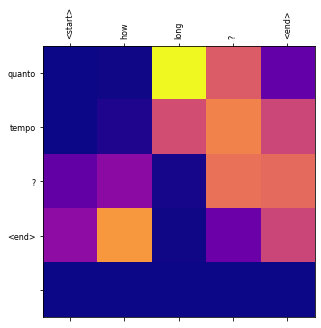

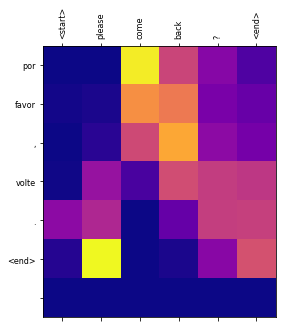

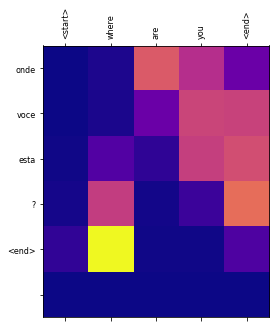

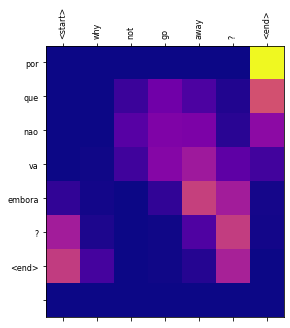

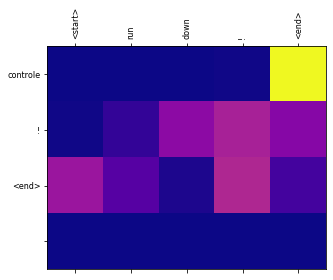

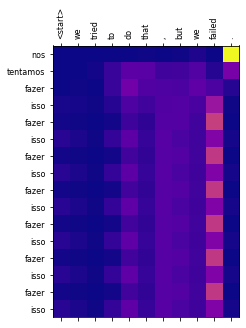

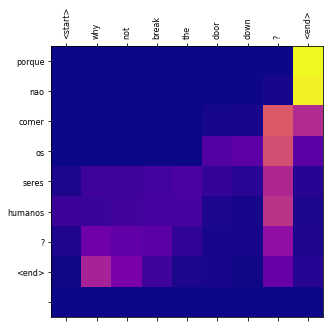

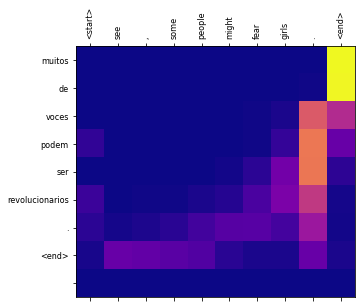

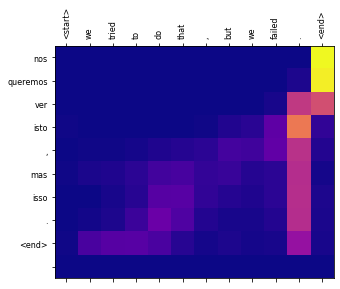

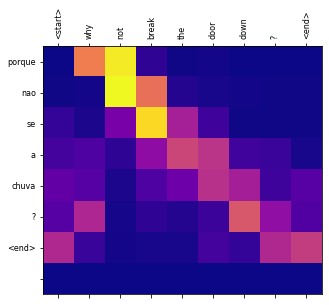

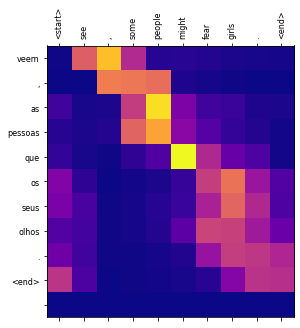

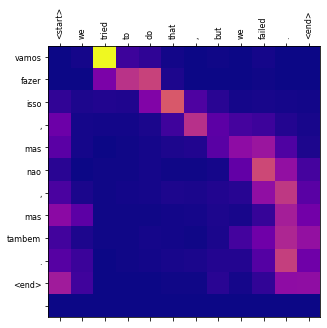

In [ ]:
# testing to get inference from attention plots and translated sentences

print("with checkpoint short")
sent = "how long?"
recurrent_type = 'lstm'
if recurrent_type == 'lstm':
  result, sentence, plot_attention = translate(sent, source_lang_tok_s, target_lang_tok_s, max_len_src_s, max_len_trg_s, lstm_enc_s, lstm_dec_s, recurrent_type)
elif recurrent_type == 'gru':
  result, sentence, plot_attention = translate(sent, source_lang_tok_s, target_lang_tok_s, max_len_src_s, max_len_trg_s, gru_enc_s, gru_dec_s, recurrent_type)

fig = plt.figure(figsize=(5,5))
axis = fig.add_subplot(1,1,1)
axis.matshow(plot_attention, cmap='plasma')
font = {'fontsize': 8}
axis.set_xticklabels(['']+sentence.split(' '), fontdict=font, rotation=90)
axis.set_yticklabels(['']+result.split(' '), fontdict=font)
axis.xaxis.set_major_locator(ticker.MultipleLocator(1))
axis.yaxis.set_major_locator(ticker.MultipleLocator(1))
print("Test 1 lstm: " +result)


sent = "please come back?"
recurrent_type = 'lstm'
if recurrent_type == 'lstm':
  result, sentence, plot_attention = translate(sent, source_lang_tok_s, target_lang_tok_s, max_len_src_s, max_len_trg_s, lstm_enc_s, lstm_dec_s, recurrent_type)
elif recurrent_type == 'gru':
  result, sentence, plot_attention = translate(sent, source_lang_tok_s, target_lang_tok_s, max_len_src_s, max_len_trg_s, gru_enc_s, gru_dec_s, recurrent_type)

fig = plt.figure(figsize=(5,5))
axis = fig.add_subplot(1,1,1)
axis.matshow(plot_attention, cmap='plasma')
font = {'fontsize': 8}
axis.set_xticklabels(['']+sentence.split(' '), fontdict=font, rotation=90)
axis.set_yticklabels(['']+result.split(' '), fontdict=font)
axis.xaxis.set_major_locator(ticker.MultipleLocator(1))
axis.yaxis.set_major_locator(ticker.MultipleLocator(1))
print("Test 2 lstm: " +result)

sent = "where are you"
recurrent_type = 'lstm'
if recurrent_type == 'lstm':
  result, sentence, plot_attention = translate(sent, source_lang_tok_s, target_lang_tok_s, max_len_src_s, max_len_trg_s, lstm_enc_s, lstm_dec_s, recurrent_type)
elif recurrent_type == 'gru':
  result, sentence, plot_attention = translate(sent, source_lang_tok_s, target_lang_tok_s, max_len_src_s, max_len_trg_s, gru_enc_s, gru_dec_s, recurrent_type)

fig = plt.figure(figsize=(5,5))
axis = fig.add_subplot(1,1,1)
axis.matshow(plot_attention, cmap='plasma')
font = {'fontsize': 8}
axis.set_xticklabels(['']+sentence.split(' '), fontdict=font, rotation=90)
axis.set_yticklabels(['']+result.split(' '), fontdict=font)
axis.xaxis.set_major_locator(ticker.MultipleLocator(1))
axis.yaxis.set_major_locator(ticker.MultipleLocator(1))
print("Test 3 lstm: " +result)


sent = "please use table."
recurrent_type = 'lstm'
if recurrent_type == 'lstm':
  result, sentence, plot_attention = translate(sent, source_lang_tok_s, target_lang_tok_s, max_len_src_s, max_len_trg_s, lstm_enc_s, lstm_dec_s, recurrent_type)
elif recurrent_type == 'gru':
  result, sentence, plot_attention = translate(sent, source_lang_tok_s, target_lang_tok_s, max_len_src_s, max_len_trg_s, gru_enc_s, gru_dec_s, recurrent_type)
print("Test 4 lstm: " +result)

sent = "Why not go away?"
recurrent_type = 'gru'
if recurrent_type == 'lstm':
  result, sentence, plot_attention = translate(sent, source_lang_tok_s, target_lang_tok_s, max_len_src_s, max_len_trg_s, lstm_enc_s, lstm_dec_s, recurrent_type)
elif recurrent_type == 'gru':
  result, sentence, plot_attention = translate(sent, source_lang_tok_s, target_lang_tok_s, max_len_src_s, max_len_trg_s, gru_enc_s, gru_dec_s, recurrent_type)

fig = plt.figure(figsize=(5,5))
axis = fig.add_subplot(1,1,1)
axis.matshow(plot_attention, cmap='plasma')
font = {'fontsize': 8}
axis.set_xticklabels(['']+sentence.split(' '), fontdict=font, rotation=90)
axis.set_yticklabels(['']+result.split(' '), fontdict=font)
axis.xaxis.set_major_locator(ticker.MultipleLocator(1))
axis.yaxis.set_major_locator(ticker.MultipleLocator(1))
print("Test 1 gru: " +result)


sent = "run down!"
recurrent_type = 'gru'
if recurrent_type == 'lstm':
  result, sentence, plot_attention = translate(sent, source_lang_tok_s, target_lang_tok_s, max_len_src_s, max_len_trg_s, lstm_enc_s, lstm_dec_s, recurrent_type)
elif recurrent_type == 'gru':
  result, sentence, plot_attention = translate(sent, source_lang_tok_s, target_lang_tok_s, max_len_src_s, max_len_trg_s, gru_enc_s, gru_dec_s, recurrent_type)

fig = plt.figure(figsize=(5,5))
axis = fig.add_subplot(1,1,1)
axis.matshow(plot_attention, cmap='plasma')
font = {'fontsize': 8}
axis.set_xticklabels(['']+sentence.split(' '), fontdict=font, rotation=90)
axis.set_yticklabels(['']+result.split(' '), fontdict=font)
axis.xaxis.set_major_locator(ticker.MultipleLocator(1))
axis.yaxis.set_major_locator(ticker.MultipleLocator(1))
print("Test 2 gru: " +result)


sent = "We tried to do that, but we failed."
recurrent_type = 'gru'
if recurrent_type == 'lstm':
  result, sentence, plot_attention = translate(sent, source_lang_tok_s, target_lang_tok_s, max_len_src_s, max_len_trg_s, lstm_enc_s, lstm_dec_s, recurrent_type)
elif recurrent_type == 'gru':
  result, sentence, plot_attention = translate(sent, source_lang_tok_s, target_lang_tok_s, max_len_src_s, max_len_trg_s, gru_enc_s, gru_dec_s, recurrent_type)

fig = plt.figure(figsize=(5,5))
axis = fig.add_subplot(1,1,1)
axis.matshow(plot_attention, cmap='plasma')
font = {'fontsize': 8}
axis.set_xticklabels(['']+sentence.split(' '), fontdict=font, rotation=90)
axis.set_yticklabels(['']+result.split(' '), fontdict=font)
axis.xaxis.set_major_locator(ticker.MultipleLocator(1))
axis.yaxis.set_major_locator(ticker.MultipleLocator(1))
print("Test 3 lstm: " +result)

sent = "where are you"
recurrent_type = 'gru'
if recurrent_type == 'lstm':
  result, sentence, plot_attention = translate(sent, source_lang_tok_s, target_lang_tok_s, max_len_src_s, max_len_trg_s, lstm_enc_s, lstm_dec_s, recurrent_type)
elif recurrent_type == 'gru':
  result, sentence, plot_attention = translate(sent, source_lang_tok_s, target_lang_tok_s, max_len_src_s, max_len_trg_s, gru_enc_s, gru_dec_s, recurrent_type)
print("Test 4 gru: " +result)

print()

print("longseq")


sent = "Why not break the door down?"
recurrent_type = 'lstm'
if recurrent_type == 'lstm':
  result, sentence, plot_attention = translate(sent, source_lang_tok_l, target_lang_tok_l, max_len_src_l, max_len_trg_l, lstm_enc_l, lstm_dec_l, recurrent_type)
elif recurrent_type == 'gru':
  result, sentence, plot_attention = translate(sent, source_lang_tok_l, target_lang_tok_l, max_len_src_l, max_len_trg_l, gru_enc_l, gru_dec_l, recurrent_type)

fig = plt.figure(figsize=(5,5))
axis = fig.add_subplot(1,1,1)
axis.matshow(plot_attention, cmap='plasma')
font = {'fontsize': 8}
axis.set_xticklabels(['']+sentence.split(' '), fontdict=font, rotation=90)
axis.set_yticklabels(['']+result.split(' '), fontdict=font)
axis.xaxis.set_major_locator(ticker.MultipleLocator(1))
axis.yaxis.set_major_locator(ticker.MultipleLocator(1))
print("Test 1 lstm: " +result)


sent = "see, some people might fear girls."
recurrent_type = 'lstm'
if recurrent_type == 'lstm':
  result, sentence, plot_attention = translate(sent, source_lang_tok_l, target_lang_tok_l, max_len_src_l, max_len_trg_l, lstm_enc_l, lstm_dec_l, recurrent_type)
elif recurrent_type == 'gru':
  result, sentence, plot_attention = translate(sent, source_lang_tok_l, target_lang_tok_l, max_len_src_l, max_len_trg_l, gru_enc_l, gru_dec_l, recurrent_type)

fig = plt.figure(figsize=(5,5))
axis = fig.add_subplot(1,1,1)
axis.matshow(plot_attention, cmap='plasma')
font = {'fontsize': 8}
axis.set_xticklabels(['']+sentence.split(' '), fontdict=font, rotation=90)
axis.set_yticklabels(['']+result.split(' '), fontdict=font)
axis.xaxis.set_major_locator(ticker.MultipleLocator(1))
axis.yaxis.set_major_locator(ticker.MultipleLocator(1))
print("Test 2 lstm: " +result)

sent = "We tried to do that, but we failed."
recurrent_type = 'lstm'
if recurrent_type == 'lstm':
  result, sentence, plot_attention = translate(sent, source_lang_tok_l, target_lang_tok_l, max_len_src_l, max_len_trg_l, lstm_enc_l, lstm_dec_l, recurrent_type)
elif recurrent_type == 'gru':
  result, sentence, plot_attention = translate(sent, source_lang_tok_l, target_lang_tok_l, max_len_src_l, max_len_trg_l, gru_enc_l, gru_dec_l, recurrent_type)

fig = plt.figure(figsize=(5,5))
axis = fig.add_subplot(1,1,1)
axis.matshow(plot_attention, cmap='plasma')
font = {'fontsize': 8}
axis.set_xticklabels(['']+sentence.split(' '), fontdict=font, rotation=90)
axis.set_yticklabels(['']+result.split(' '), fontdict=font)
axis.xaxis.set_major_locator(ticker.MultipleLocator(1))
axis.yaxis.set_major_locator(ticker.MultipleLocator(1))
print("Test 3 lstm: " +result)

sent = "please use our table"
recurrent_type = 'lstm'
if recurrent_type == 'lstm':
  result, sentence, plot_attention = translate(sent, source_lang_tok_l, target_lang_tok_l, max_len_src_l, max_len_trg_l, lstm_enc_l, lstm_dec_l, recurrent_type)
elif recurrent_type == 'gru':
  result, sentence, plot_attention = translate(sent, source_lang_tok_l, target_lang_tok_l, max_len_src_l, max_len_trg_l, gru_enc_l, gru_dec_l, recurrent_type)
print("Test 4 lstm: " +result)

sent = "Why not break the door down?"
recurrent_type = 'gru'
if recurrent_type == 'lstm':
  result, sentence, plot_attention = translate(sent, source_lang_tok_l, target_lang_tok_l, max_len_src_l, max_len_trg_l, lstm_enc_l, lstm_dec_l, recurrent_type)
elif recurrent_type == 'gru':
  result, sentence, plot_attention = translate(sent, source_lang_tok_l, target_lang_tok_l, max_len_src_l, max_len_trg_l, gru_enc_l, gru_dec_l, recurrent_type)

fig = plt.figure(figsize=(5,5))
axis = fig.add_subplot(1,1,1)
axis.matshow(plot_attention, cmap='plasma')
font = {'fontsize': 8}
axis.set_xticklabels(['']+sentence.split(' '), fontdict=font, rotation=90)
axis.set_yticklabels(['']+result.split(' '), fontdict=font)
axis.xaxis.set_major_locator(ticker.MultipleLocator(1))
axis.yaxis.set_major_locator(ticker.MultipleLocator(1))
print("Test 1 gru: " +result)

sent = "see, some people might fear girls."
recurrent_type = 'gru'
if recurrent_type == 'lstm':
  result, sentence, plot_attention = translate(sent, source_lang_tok_l, target_lang_tok_l, max_len_src_l, max_len_trg_l, lstm_enc_l, lstm_dec_l, recurrent_type)
elif recurrent_type == 'gru':
  result, sentence, plot_attention = translate(sent, source_lang_tok_l, target_lang_tok_l, max_len_src_l, max_len_trg_l, gru_enc_l, gru_dec_l, recurrent_type)

fig = plt.figure(figsize=(5,5))
axis = fig.add_subplot(1,1,1)
axis.matshow(plot_attention, cmap='plasma')
font = {'fontsize': 8}
axis.set_xticklabels(['']+sentence.split(' '), fontdict=font, rotation=90)
axis.set_yticklabels(['']+result.split(' '), fontdict=font)
axis.xaxis.set_major_locator(ticker.MultipleLocator(1))
axis.yaxis.set_major_locator(ticker.MultipleLocator(1))
print("Test 2 gru: " +result)


sent = "We tried to do that, but we failed."
recurrent_type = 'gru'
if recurrent_type == 'lstm':
  result, sentence, plot_attention = translate(sent, source_lang_tok_l, target_lang_tok_l, max_len_src_l, max_len_trg_l, lstm_enc_l, lstm_dec_l, recurrent_type)
elif recurrent_type == 'gru':
  result, sentence, plot_attention = translate(sent, source_lang_tok_l, target_lang_tok_l, max_len_src_l, max_len_trg_l, gru_enc_l, gru_dec_l, recurrent_type)

fig = plt.figure(figsize=(5,5))
axis = fig.add_subplot(1,1,1)
axis.matshow(plot_attention, cmap='plasma')
font = {'fontsize': 8}
axis.set_xticklabels(['']+sentence.split(' '), fontdict=font, rotation=90)
axis.set_yticklabels(['']+result.split(' '), fontdict=font)
axis.xaxis.set_major_locator(ticker.MultipleLocator(1))
axis.yaxis.set_major_locator(ticker.MultipleLocator(1))
print("Test 3 gru: " +result)

sent = "please use our table"
recurrent_type = 'gru'
if recurrent_type == 'lstm':
  result, sentence, plot_attention = translate(sent, source_lang_tok_l, target_lang_tok_l, max_len_src_l, max_len_trg_l, lstm_enc_l, lstm_dec_l, recurrent_type)
elif recurrent_type == 'gru':
  result, sentence, plot_attention = translate(sent, source_lang_tok_l, target_lang_tok_l, max_len_src_l, max_len_trg_l, gru_enc_l, gru_dec_l, recurrent_type)
print("Test 4 gru: " +result)
